# Naive Bayes

## Introduction

The data set that will be used for Naive Bayes classification is from the Big Five Personality data. This data set contains 212,625 individuals from the U.S. Our goal is to see if there are certain personality traits (from agreeableness, extraversion, openness, conscientiousness, and neuroticism) are strongly associated with men or women. We will also apply the Naive Bayes classifier to the Wikipedia data. This data set contains sentences from various Wikipedia pages related to the search terms "Women's Rights" and "Men's Rights." For the specific code that achieved these data sets, please refer to the data cleaning section. For further detail about these data sets, please refer to the exploring data section.

## Theory

Naive Bayes is a probabilistic classifier model that is used for determining to which group (or "class") an instance would *most likely* belong. As such, Naive Bayes classification allows us to determine the probability of specified features occurring for each variable and categorize said variable to the most likely class. Naive Bayes classifiers is rooted in Bayes' Theorem, and as such, it has the assumption of independence among the features (i.e. one feature has no effect on another), making it "naive." 

There are multiple Naive Bayes classifiers. The Gaussian Naive Bayes algorithm assumes that the data comes from a normal (hence "Gaussian") distribution and is applied when the features are continuous. The Multinomial Naive Bayes algorithm is applied when the features are discrete and is frequently used for document classification. The Gaussian Naive Bayes algorithm will be applied to the Big Five Personality data, since the personality trait scores are continuous values ranging from 0 to 1, and the Multinomial Naive Bayes algorithm will be applied to the Wikipedia data, which has one-hot encoded sentences.

## Methods

### Gaussian Naive Bayes


```{r}
## imports
library(ggplot2)
library(tidyverse)
library(e1071)
library(caTools)
library(caret)
library(naivebayes)

## read in data
df <- read.csv('../../../data/01-modified-data/big_five_final.csv')
df <- df %>% select(-c(age, case_id, country)) %>%
        mutate(sex = factor(ifelse(sex == 1, 'Male', 'Female')))
df$sex <- as.factor(df$sex)
df_m <- df %>% filter(sex=='Male')
df_f <- df %>% filter(sex=='Female')

## split data
set.seed(123)

## ref: https://www.learnbymarketing.com/tutorials/naive-bayes-in-r/
split <- sample.split(df, SplitRatio=0.8)
train_m <- subset(df_m, split=='TRUE')
test_m <- subset(df_m, split=='FALSE')
train_f <- subset(df_f, split=='TRUE')
test_f <- subset(df_f, split=='FALSE')
train <- rbind(train_m, train_f)
test <- rbind(test_m, test_f)
```


Naive Bayes was used to predict the sex of an individual living in the U.S. based on the Big Five Personality data set. The predictor variables used in training the model were agreeableness, extraversion, openness, conscientiousness, and neuroticism scores. Upon closer inspection of the data, we can see that there are a little over 60% more women in the data set than men. In order to account for this, the data was split by sex. Then, to the sex-separated data sets, the data was further split 80-20 into training and test sets. Once creating training and test sets for each sex, the training and test sets were merged again to create one training and one test set. In doing this, the female:male ratio can be preserved in both the training and test sets, which should result in a more accurate and reflective Naive Bayes classification.


```{r}
classifier <- naiveBayes(sex ~ ., data=train)
modelPred <- predict(classifier, test)
confusion <- table(modelPred, test$sex)
confusionMatrix(confusion)
```


Upon using the Naive Bayes model on the aforementioned training and test data sets, the output on the left was determined. The Naive Bayes model resulted in an extremely low p-value, which suggests that this is a reliable method for predicting an individual's sex based on their Big Five Personality scores. However, an accuracy of 0.6782 suggests that the model itself is not extremely strong.


```{r}
## ref: https://stackoverflow.com/questions/37897252/plot-confusion-matrix-in-r-using-ggplot
Target <- factor(c('Male', 'Male', 'Female', 'Female'))
Prediction <- factor(c(0, 1, 0, 1))
Y      <- c(18287, 8375, 39694, 4519)
df <- data.frame(Target, Prediction, Y)
ggplot(df, aes(x = Target, y = Prediction)) +
        geom_tile(aes(fill = Y), color = "white") +
        geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
        scale_fill_gradient(low = "lightblue", high = "salmon") +
        scale_x_discrete(labels=c("Female","Male")) +
        scale_y_discrete(labels=c("Female","Male")) +
        labs(title = 'Confusion Matrix') + 
        theme_bw() + 
        theme(legend.position = "none", plot.title = element_text(hjust = 0.5))
```


The confusion matrix statistical output can also be visualized with a confusion matrix plot, shown on the right. An interesting detail to note is the relatively high number of false positives from the Naive Bayes classification. The bottom right corner shows that the model incorrectly predicted a male individual as female over 18,000 times. This may be the result from having an unevenly balanced data set, where there were over 60% more women than men.


```{r}
#| layout-ncol: 3
#| layout-align: center
big5 <- naive_bayes(as.factor(sex) ~., data=train)
plot(big5, vars = c("agreeable_score","extraversion_score","openness_score",
                    "conscientiousness_score","neuroticism_score"))
```


Marginal probabilities of the predictor variables (agreeable_score, extraversion_score, openness_score, conscientiousness_score, and neuroticism_score) based on class are also visualized above.

## Conclusions

The model itself isn't very strong. Since there are only two classifier groups (i.e. Male or Female), random guesses would result in an accuracy of 0.5. As such, our model is only 17-18% better than if the model were to just guess an individual's randomly. This makes the model not great, but not completely useless; rather, these results suggest that this model shouldn't be the sole determinant for predicting an individual's sex from their Big Five Personality scores.

## Multinomial Naive Bayes

In [5]:
## imports
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

#RELOAD FILE AND PRETEND THAT IS OUR STARTING POINT 
#df=pd.read_csv('../../../data/00-raw-data/wiki-crawl-results.csv')  
df=pd.read_csv('./data/00-raw-data/wiki-crawl-results.csv')

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; #y1=[]; y2=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
corpus=df["text"].to_list()
y2=df["sentiment"].to_numpy()

# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# PARTITION DATASET INTO TRAINING-TEST

from sklearn.model_selection import train_test_split
test_ratio=0.2

# SPLIT ARRAYS OR MATRICES INTO RANDOM TRAIN AND TEST SUBSETS.
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=1234)
y_train=y_train.flatten()
y_test=y_test.flatten()

## helper functions
def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

Similar analysis was conducted using the sentences gathered from various Wikipedia pages for searches that related to the keywords "Women's rights" and "Men's rights." By using Naive Bayes classification on this data set, we attempted to classify the vectorized text data to either of the aforementioned search terms.


In [6]:
from sklearn.naive_bayes import MultinomialNB

# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 97.02380952380952
Number of mislabeled points out of a total 336 points = 10

TEST SET (UNTRAINED DATA):
Accuracy: 80.95238095238095
Number of mislabeled points out of a total 84 points = 16

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1]
[1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

TEST SET (UNTRAINED DATA):
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1]
[1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1]
ERRORS: [1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]


Based on the model summary output, we can see that the trained Naive Bayes classifier had an accuracy of 0.82 on the test set.


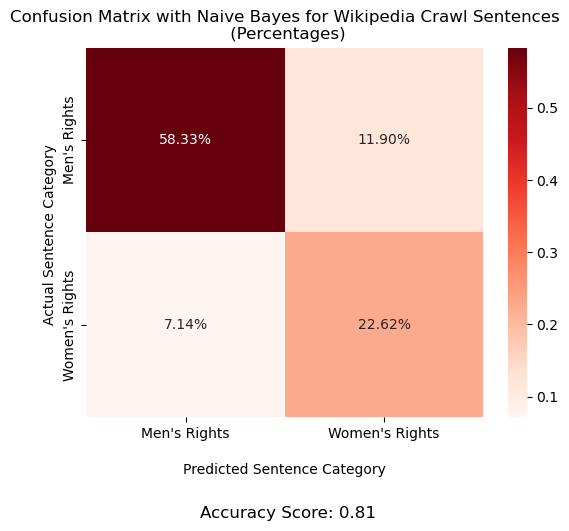

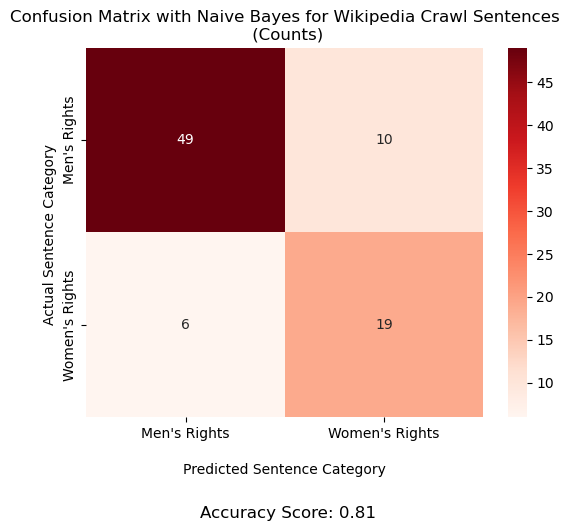

In [7]:
#| layout-ncol: 2
#| layout-align: center

# ref: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=You%20can%20create%20the%20confusion,False%20Negatives%2C%20and%20True%20negatives.
y_pred = model.predict(x_test)
accuracy_score = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix (percentages)
ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Reds')

ax.set_title('Confusion Matrix with Naive Bayes for Wikipedia Crawl Sentences\n (Percentages)')
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Men's Rights", "Women's Rights"])
ax.yaxis.set_ticklabels(["Men's Rights", "Women's Rights"])
txt="Accuracy Score: {:0.2f}".format(accuracy_score)
plt.figtext(0.44, -.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

## Display the visualization of the Confusion Matrix.
plt.show();

# Confusion Matrix (raw)
ax = sns.heatmap(cm, annot=True, cmap='Reds')

ax.set_title('Confusion Matrix with Naive Bayes for Wikipedia Crawl Sentences\n (Counts)')
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category ')
plt.figtext(0.44, -.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Men's Rights", "Women's Rights"])
ax.yaxis.set_ticklabels(["Men's Rights", "Women's Rights"])

## Display the visual
plt.show();

The aforementioned analysis can also be visualized with the following confusion matrices below.


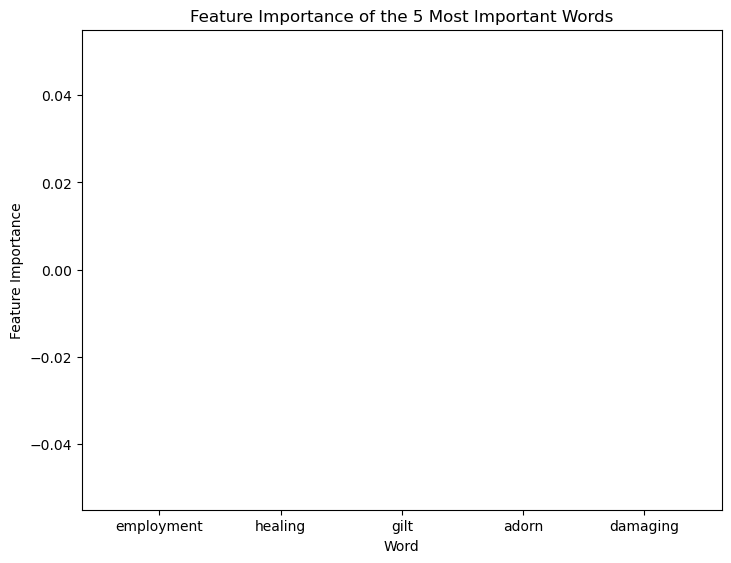

In [8]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(model, x_test, y_test)
means = imps.importances_mean

vocab0 = vectorizer.vocabulary_
vocab1 = dict([(value, key) for key, value in vocab0.items()])
d={'words': vocab1.values(), 'importance': means}
df2=pd.DataFrame(d)
df2.sort_values('importance', ascending=False, inplace=True)

most_important = df2.head(n=5)
least_important = df2.tail(n=5)

In [17]:
print("Most Important Words:")
print(most_important)
print("Least Important Words:")
print(least_important)

Most Important Words:
           words  importance
0     employment         0.0
6595     healing         0.0
6588        gilt         0.0
6589       adorn         0.0
6590    damaging         0.0
Least Important Words:
            words  importance
7573    commandan   -0.011905
9311  intelligent   -0.011905
4781   mishandled   -0.011905
2151      liberty   -0.011905
9091  detrimental   -0.011905


Text(0.5, 0, 'Word')

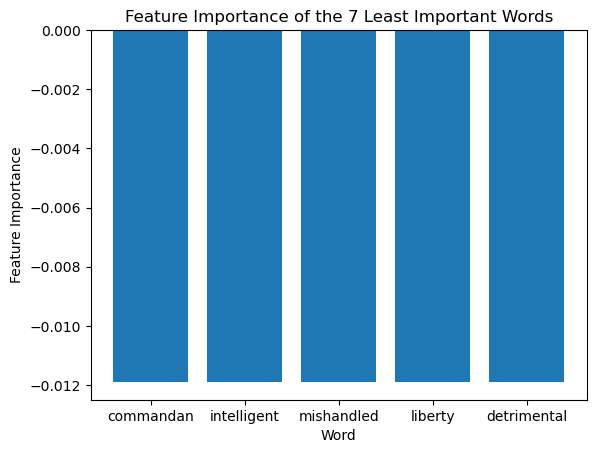

In [22]:
fig, ax = plt.subplots()
ax.bar(least_important['words'],least_important['importance'])
ax.set_ylabel('Feature Importance')
ax.set_title('Feature Importance of the 7 Least Important Words')
ax.set_xlabel('Word')

Additionally, we can extract feature importance. The plots above show the 5 most and least important words gathered by the model.

## Conclusions

Again, since there are only two classifier groups (i.e. the two search terms), random guesses would result in an accuracy of 0.5. As such, our model performs a little over 30% better than if the model were to just guess randomly based on given words in a sentence. This suggests that the model performs decently well in determining which sentences generally are associated with either "Women's rights" or "Men's rights."
